# Sistema de Recomendação com a biblioteca Surprise
Aqui nós vamos implementar um simples **Sistema de Recomendação** com a biblioteca **[Surprise](http://surpriselib.com/)**. O objetivo principal é testar alguns dos recursos básico da biblioteca.

## 01 - Preparando o Ambiente & Conjunto de dados

### 01.1 - Baixando a biblioteca "surprise"
A primeira coisa que nós vamos fazer é baixar a biblioteca **[Surprise](http://surpriselib.com/)** que é uma biblioteca especifica para **Sistemas de Recomendação**.

In [1]:
#conda install -c conda-forge scikit-surprise
#!pip install scikit-surprise

### 01.2 - Importando as bibliotecas necessárias
Agora vamos importar as bibliotecas necessárias para criar nosso **Sistema de Recomendação**.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import surprise

from datetime import datetime

### 01.3 - Pegando o conjunto de dados
Agora nós vamos pegar o conjunto de dados **[FilmTrust](https://guoguibing.github.io/librec/datasets.html)** que basicamente vai ter:

 - ID dos usuários;
 - ID do filme;
 - Nota (rating) que foi dado ao filme.

In [3]:
df = pd.read_csv(
  "datasets/ratings.txt", # Get dataset.
  sep=" ", # Separate data by space.
  names=["user_id", "movie_id", "rating"] # Set columns names.
)

In [4]:
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35497 entries, 0 to 35496
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   35497 non-null  int64  
 1   movie_id  35497 non-null  int64  
 2   rating    35497 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 832.1 KB


,user_id,movie_id,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0
5,1,6,3.5
6,1,7,3.5
7,1,8,3.0
8,1,9,2.5
9,1,10,4.0


**NOTE:**  
Vejam que nós temos **35.497** amostras e 3 colunas (features).

---

## 02 - Análise Exploratória dos dados (EDA)
Agora nós vamos fazer uma breve **Análise Exploratória dos dados (EDA)** no nosso conjunto de dados a fim de tirar insights dos mesmos.

### 02.1 - Contabilizando o número total de filmes (movies), usuários (users) e amostras (samples)

In [5]:
movies  = len(df["movie_id"].unique())
users   = len(df["user_id"].unique())
samples = df.shape[0]

print("Total movies:", movies)
print("Total users:", users)
print("Total samples:", samples)

Total movies: 2071
Total users: 1508
Total samples: 35497


**NOTE:**  
Como podem ver nós temos apenas **35.497** amostras, mas as combinações entre **filmes (movies)** e **usuários (users)** é bem maior que isso:

```python
2.071 x 1.508 = 3.123.068
```

Ou seja, temos muitos dados faltantes (missing) e isso pode ocorrer porque alguns usuários apenas não viram determinados filmes. Por isso, vai ser interessante tentar ***prever*** esses valores.

Por exemplo, vamos olhar as 20 primeiras amostras:

In [6]:
df.head(20)

,user_id,movie_id,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0
5,1,6,3.5
6,1,7,3.5
7,1,8,3.0
8,1,9,2.5
9,1,10,4.0


**NOTE:**  
Com apenas 20 amostras já da para tirar algumas concluções:
 - O usuário 1 viu apenas 12 filmes:
   - Ou seja, teremos que fazer inúmeras previsões de notas (rating) de filmes para esse usuário.
 - O usuário 2 viu apenas 2 filme:
   - Pior ainda, podemos ter até um problema de underfitting para prever notas (rating) para esse usuário visto que o nosso Algoritmo não vai generalizar o suficiente.

### 02.2 - Contabilizando o número de  notas (rating)

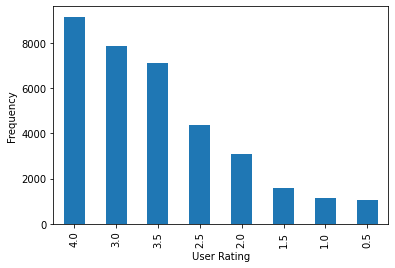

In [7]:
df['rating'].value_counts().plot(kind="bar")
plt.xlabel("User Rating")
plt.ylabel("Frequency")
plt.show()

**NOTE:**  
Olhando para o gráfico acima nós temos que:
 - A nota (rating) mínima foi 0.5;
 - A nota (rating) máxima foi 4.0;
 - A nota (rating) mais frequente foi 4.0.

Vamos ver esse mesmo resultado, porém, utilizando outra abordagem, apenas para fins de ensino.

In [8]:
max_rating = df["rating"].max()
min_rating = df["rating"].min()
print("Max rating: {0} \nMin rating: {1}".format(max_rating, min_rating))

Max rating: 4.0 
Min rating: 0.5


---

## 03 - Preparando & Treinando um modelo para Sistema de Recomendação

### 03.1 - Redefinindo o range (escala) do ratings
Por padrão a classe **surprise.Reader** tem o range (escala) de rating de **rating_scale=(1, 5)**, então, vamos redefinir esse parâmetro para se ajustar a nossa necessidade, ou seja, de **0.5** até **4.0**.

Para utilizar um conjunto de dados externos da biblioteca Surprise (visto que ela também tem conjuntos de dados prontos para testes) você antes tem que utilizar a classe [Reader](https://github.com/NicolasHug/Surprise/blob/fa7455880192383f01475162b4cbd310d91d29ca/surprise/reader.py). Essa classe, tem o seguinte construtor por padrão (default):

```python
def __init__(
  self,
  name=None,
  line_format='user item rating',
  sep=None,
  rating_scale=(1, 5),
  skip_lines=0
):
```

Vamos criar uma instância dessa classe apenas passando como argumento o que nos interessa - **rating_scale = (0.5, 4.0)**

In [9]:
reader = surprise.Reader(rating_scale = (0.5, 4.0))

### 03.2 - Passando o nosso conjunto de dados (DataFrame Pandas) para o Surprise
A biblioteca Surprise tem uma abordagem um pouco diferente de se trabalhar. Uma delas é na hora de passar dados externos para a biblioteca, por exemplo, para passar um DataFrame Pandas nós podemos utilizar o método **load_from_df()** da classe **Dataset**.

Esse método recebe os seguintes argumentos:
 - **df (Dataframe):**
   - O dataframe que contém as classificações. Ele deve ter três colunas, correspondentes aos:
     - ids do usuário;
     - aos ids do item (filmes no nosso caso);
     - e às classificações (ratings), nesta ordem.
 - **leitor (Reader):**
   - Um leitor (Reader) para ler o arquivo. Apenas o campo **rating_scale**  precisa ser especificado.

In [10]:
# Load df to surprise library + Pass rating_scale by Reader class.
df_surprise = surprise.Dataset.load_from_df(df, reader)

### 03.3 - Criando um conjunto de dados de treinamento a partir de "df_surprise"
Como nós vimos no passo anterior, nós passamos nosso conjunto de dados para a biblioteca Surprise e salvamos isso na variável **df_surprise**. Agora nós vamos pegar todo esse conjunto de dados e criar um conjunto de dados de treinamento (isso mesmo, sem dados de validação/teste).

Para isso nós vamos utilizar o método **build_full_trainset()** da classe **[Dataset](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.DatasetAutoFolds.build_full_trainset)**:

In [11]:
df_without_missing = df_surprise.build_full_trainset()

**NOTE:**  
Eu deixei bem explicito a partir do nome da variável (df_without_missing) que esse conjunto de dados de treinamento não vai conter valores **faltantes/missing**.

### 03.4 - Criando uma instância do Algoritmo SVD++
Como nós sabemos uma das abordagens para fazer previsões em Sistemas de Recomendações é utilizando **Matrix Factorization** que é uma abordagem baseada em **Filtragem Colaborativa**.

**NOTE:**  
Esse Algoritmo vai criar *características (features)* para os usuários e itens (filmes no nosso caso) e a partir dessas *características (features)* nós podemos fazer previsões futuras.

A primeira coisa que nós vamos fazer aqui é criar uma instância do Algoritmo SVD++:

In [12]:
algo_svdpp = surprise.SVDpp(n_factors=20) # SVD++ instance.

### 03.5 - Criando as características (features) a partir do Algoritmo SVD++
Para criar as *características (features)* é muito simples, basta treinar nosso modelo com o método **fit()** passando como argumento um conjunto de dados.

In [13]:
algo_svdpp.fit(df_without_missing)

**NOTE:**  
A parte do código acima nada mais do que utilizar o algoritmo **SVD++** para criar as *features* para o nosso conjunto de dados. Por padrão, o algoritmo criar 20 features (n_factors=20). Outra observação é que ele está utilizando o método **Matrix Factorization** como pode ser visto na saída acima.

### 03.6 - Criando um DataFrame com os dados faltantes/missing
Como nós sabemos, nós temos:

```python
Total movies: 2071
Total users: 1508
Total samples: 35497
```

O que nos resultaria em:

```python
2.071 x 1.508 = 3.123.068
```

Ou seja, ainda faltam milhões de combinações de usuários e notas (rating) para filmes. Como nós criamos as *features* para esse conjunto de dados agora vamos ***prever*** as combinações faltantes.

Para isso primeiro nós vamos utilizar o método **build_anti_testset()** a partir da nossa variável **df_without_missing (nosso conjunto de dados sem dados missing)**. Esse método retorna uma lista de classificações (ratings) que podem ser usadas como um conjunto de testes.

Por exemplo, primeiro vamos pegar as combinações que faltam para o nosso conjunto de dados, ou seja, os dados faltantea/missing:

In [14]:
df_missing_values = df_without_missing.build_anti_testset()

Se você utilizar a função **len(df_missing_values)** vai ver que existem milhões de combinações que estavam faltando e agora nosso algoritmo **SVD++** *preveu (estimou)*.

In [15]:
len(df_missing_values)

3087574

**Ué, mas essa saída é menos do que o tamanho máximo de combinações possíveis!**  
Lembrem, que essa saída são apenas os faltantes/missing. Nós devemo subtrair to número total às **35.497** amostras que nós já temos:

```python
(Total movies: 2071) * (Total users: 1508)
2.071 x 1.508 = 3.123.068

(Total combinations: 3.123.068) - (Samples we already had: 35497) = 3.087.574
```

Ótimo agora nós já temos as combinações que faltavam salvos na variável **df_missing_values**. Só para estudos mesmo, vou criar uma mecanismo abaixo que **printa()** as 10 primeiras combinações que faltavam, isso porque se a gente tinha toda a variável **df_missing_values** vai dar uma saída muito grande.

In [16]:
count = 0
while count < 10:
  print(df_missing_values[count])
  count += 1

(1, 13, 3.0028030537791928)
(1, 14, 3.0028030537791928)
(1, 15, 3.0028030537791928)
(1, 16, 3.0028030537791928)
(1, 17, 3.0028030537791928)
(1, 18, 3.0028030537791928)
(1, 19, 3.0028030537791928)
(1, 20, 3.0028030537791928)
(1, 21, 3.0028030537791928)
(1, 22, 3.0028030537791928)


**NOTE:**  
Se vocês compararem essa saída com a do nosso conjunto de dados originais (sem previsões alguma) vai ver que o primeiro usuário só deu notas (rating) até o filme com ID 12. Ou seja, o nosso Algoritmo SVD++ fez as previsões para as combinações que faltavam.

### 03.7 - Relacionando todos os dados em um único objeto
Agora nós vamos utilizar o método **test()** do modelo SVD++ (objeto) para fazer uma relação entre os dados que os usuários já tinham passado e os que nós prevemos (estimamos), onde, vamos ter:
 - **uid:**
   - ID do usuário.
 - **iid:**
   - ID do filme.
 - **r_ui:**
   - A resposta real. Ou seja, o valor passado pelo usuário.
 - **est:**
   - O valora/nota (rating) previsto/estimado.


In [17]:
df_complete = algo_svdpp.test(df_missing_values)

Agora que nós já temos um objeto com todos os valores possíveis vamos dar uma olhada na primeira previsão:

In [18]:
df_complete[0]

Prediction(uid=1, iid=13, r_ui=3.0028030537791928, est=3.6828465783892663, details={'was_impossible': False})

**NOTE:**  
Vejam que tem uma pequena diferença entre o valor que o usuário passou **r_ui** e o valor estimado pelo Algoritmo SVD++ **est**:
 - r_ui=3.0028030537791928
 - est=3.530673400436856

### 03.8 - Pegando as TOP recomendações por usuário
Agora nós vamos criar uma função que retorne o top-N recomendações para cada usuário. Essa função retorna um **dicionário**, onde, as chaves são os usuários e os valores são listas de tuplas.

In [19]:
from collections import defaultdict

def get_top_recommendations(predicts, n=5):
  top_n = defaultdict(list) # Create a dictionary where lists are empty.
  for user, movie, _, predict, _ in predicts:
    top_n[user].append((movie, predict)) # Add key-value
  for user, user_predicts in top_n.items():
    user_predicts.sort(key=lambda x: x[1], reverse=True) # Order predicts rating from high to less.
    top_n[user] = user_predicts[:n] # Save only the first values.
  return top_n

Vamos começar pegando as top 5 recomendações (que é o valor default da função get_top_recommendations) para cada usuário:

In [20]:
top_five = get_top_recommendations(df_complete)

In [21]:
top_five

defaultdict(list,
            {1: [(286, 4.0),
              (805, 3.9828344086963683),
              (335, 3.956421278324072),
              (728, 3.883580182019794),
              (307, 3.8785290956083256)],
             2: [(805, 3.6090055440425366),
              (286, 3.5926396744972076),
              (335, 3.5471051806008913),
              (658, 3.4786112088599035),
              (675, 3.4716339688778612)],
             3: [(253, 4.0),
              (797, 4.0),
              (5, 3.9557967392128957),
              (7, 3.922893318673688),
              (2, 3.8828095064969284)],
             4: [(286, 3.4133424427965613),
              (805, 3.2749760406662114),
              (391, 3.2547114756693913),
              (2, 3.2338038251486823),
              (318, 3.2206384996037696)],
             5: [(286, 3.915723277812156),
              (805, 3.8025197472561807),
              (335, 3.766787145760567),
              (705, 3.653288743450758),
              (414, 3.6455252489846606

Olhando para a saída acima nós temos:
 - Um dicionário onde:
   - A chave é o ID do usuário
   - E os valores são uma lista de duplas, onde:
     - O primeiro elemento da tupla representa o ID do filme;
     - O segundo elemento da tupla representa a nota (rating) do filme.
     - Isso tudo em ordem decrescente, ou seja, da maior nota (rating) para a menor.

**NOTE:**  
Agora você pode pegar essa saída e trabalhar com ela da maneira que você desejar, por exemplo, passar para uma API e etc. Só por questão didática vamos pegar essa saída (dicionário) e criar uma mecanismo, onde, nós vamos ter o ID do usuário e uma lista com os top 5 filmes por ID e não por nota (rating).

In [22]:
for user, user_predicts in top_five.items():
  print(user, [movie for (movie, _) in user_predicts])

1 [286, 805, 335, 728, 307]
2 [805, 286, 335, 658, 675]
3 [253, 797, 5, 7, 2]
4 [286, 805, 391, 2, 318]
5 [286, 805, 335, 705, 414]
6 [286, 805, 689, 318, 335]
7 [286, 805, 218, 335, 675]
8 [335, 286, 805, 705, 658]
9 [286, 805, 335, 705, 563]
10 [805, 286, 335, 363, 689]
11 [286, 805, 335, 675, 705]
12 [286, 805, 335, 218, 307]
13 [286, 805, 335, 705, 689]
14 [286, 805, 689, 705, 307]
15 [286, 805, 335, 563, 307]
16 [286, 335, 805, 425, 299]
17 [286, 805, 318, 335, 689]
18 [286, 805, 335, 705, 728]
19 [286, 805, 335, 563, 689]
20 [805, 286, 335, 307, 705]
21 [52, 126, 144, 189, 218]
22 [52, 68, 96, 126, 167]
23 [286, 805, 318, 218, 335]
24 [335, 286, 805, 658, 705]
25 [335, 805, 286, 689, 446]
26 [286, 805, 335, 696, 318]
27 [805, 286, 335, 563, 705]
28 [286, 335, 805, 705, 563]
29 [335, 705, 675, 658, 702]
30 [286, 805, 335, 1091, 307]
31 [286, 805, 335, 705, 728]
32 [286, 335, 805, 705, 728]
33 [286, 805, 689, 335, 728]
34 [286, 318, 805, 218, 563]
35 [286, 805, 363, 335, 689]
36 [2

913 [335, 286, 805, 705, 307]
914 [286, 805, 335, 307, 658]
915 [286, 335, 805, 675, 318]
916 [286, 805, 363, 318, 335]
917 [286, 805, 335, 318, 307]
918 [335, 805, 286, 293, 658]
919 [286, 805, 335, 318, 218]
920 [286, 805, 335, 696, 293]
921 [286, 318, 805, 335, 400]
922 [286, 805, 335, 218, 705]
923 [286, 805, 335, 689, 675]
924 [286, 335, 307, 805, 218]
925 [805, 286, 689, 335, 363]
926 [286, 805, 689, 335, 218]
927 [286, 335, 805, 689, 318]
928 [286, 805, 335, 307, 1091]
929 [286, 805, 335, 242, 658]
930 [286, 805, 335, 307, 1091]
931 [286, 805, 335, 705, 689]
932 [286, 805, 335, 689, 1118]
933 [286, 335, 805, 425, 689]
934 [805, 286, 335, 307, 563]
935 [286, 293, 297, 299, 307]
936 [286, 805, 335, 705, 728]
937 [96, 144, 189, 197, 218]
938 [335, 286, 805, 307, 400]
939 [286, 805, 335, 425, 363]
940 [189, 218, 286, 293, 297]
941 [286, 335, 658, 805, 400]
942 [286, 335, 805, 425, 728]
943 [805, 286, 335, 675, 705]
944 [68, 286, 292, 299, 318]
945 [286, 805, 335, 689, 675]
946 [805,

**NOTE:**  
Uma observação aqui é que esses ID dos filmes estão ordenados de modo que os filmes que tiveram melhor nota (rating) sejam os primeiros.

> Então, não confunda o ID dos filmes com as notas (rating).

### 03.9 - Pegando previsões específicas de usuários por filme
Ok, mas como eu posso pegar uma previsão para um usuário e filme específico? Simples, vejam o código abaixo:

In [23]:
user_1_predict = algo_svdpp.predict(uid="1", iid="15")
user_1_predict

Prediction(uid='1', iid='15', r_ui=None, est=3.0028030537791928, details={'was_impossible': False})

**NOTES:**  
 - A primeira observação aqui e crucial é que o usuáro não tinha passado uma nota (rating) para esse filme:
   - r_ui=None
 - Nós também podemos pegar a nota (rating) que foi prevista apenas utilizando o atributo **est**:

In [24]:
rating = user_1_predict.est
print(rating)

3.0028030537791928


---

## 04 - Validando nosso modelo

> Ótimo, nós já treinamos um modelo; Fizemos previsões, mas falta ***validar*** esse modelo.

### 04.1 - Dividindo os dados em dados de treino e dados de teste (validação)
Da mesma maneira que a biblioteca *Scikit-Learn* tem o método **train_test_split()** a biblioteca surprise tem o mesmo para Sistemas de Recomendação.

In [25]:
from surprise.model_selection import train_test_split
df_train, df_test = train_test_split(df_surprise, test_size=0.3)

**NOTE:**  
Uma observação aqui é que nós estamos passando o **df_surprise** que é um load do método **load_from_df()**:

```python
df_surprise = surprise.Dataset.load_from_df(df, reader)
```

Ou seja, nós estamos passando o conjunto de dados reais, sem dados faltantes/missing.

### 04.2 - treinando o modelo com os dados de treino
Agora o que nós vamos fazer é criar uma instância do nosso Algoritmo SVD++ e treinar nosso modelo com os dados de treino (df_train):

In [26]:
model_svdpp = surprise.SVDpp(n_factors=20) # SVD++ Instance.
model_svdpp = model_svdpp.fit(df_train)

### 04.3 - Fazendo previsões com os dados de teste (validação)
Agora que nós já treinamos nosso modelo com o método fit() e os dados de treino vamos fazer algumas predições com os dados de teste (validação):

In [27]:
general_predicts = model_svdpp.test(df_test)

Eu vou criar um mecanismo simples para demonstrar apenas as 10 primeiras previsões, visto que nossa saída era muito grande, vamos apenas visualizar as 10 primeiras:

In [28]:
count = 0
while count < 10:
  print(general_predicts[count])
  count += 1

user: 161        item: 352        r_ui = 2.50   est = 2.66   {'was_impossible': False}
user: 788        item: 3          r_ui = 3.00   est = 2.61   {'was_impossible': False}
user: 385        item: 211        r_ui = 3.50   est = 2.80   {'was_impossible': False}
user: 555        item: 10         r_ui = 3.50   est = 3.36   {'was_impossible': False}
user: 815        item: 121        r_ui = 0.50   est = 1.79   {'was_impossible': False}
user: 747        item: 250        r_ui = 3.00   est = 3.48   {'was_impossible': False}
user: 1454       item: 7          r_ui = 2.50   est = 2.33   {'was_impossible': False}
user: 669        item: 256        r_ui = 2.50   est = 2.89   {'was_impossible': False}
user: 91         item: 242        r_ui = 3.00   est = 3.58   {'was_impossible': False}
user: 830        item: 1301       r_ui = 2.50   est = 3.29   {'was_impossible': False}


**NOTE:**  
Como os dados estão divididos em **treino** e **teste (validação)** você não vai ter os dados ordenados para trabalhar. Vai receber um conjunto de dados aleatório entre treino e teste. Se for de seu interesse você pode comparar as saídas das 10 primeiras amostras pegando pelo índice da variável **general_predicts**:

In [29]:
general_predicts[0]

Prediction(uid=161, iid=352, r_ui=2.5, est=2.6620107289006008, details={'was_impossible': False})

**NOTE:**  
Vejam que ela realmente corresponde a saída que nós tinhamos passado antes.

### 04.4 - Validando o modelo com a métrica "accuracy.rmse"
A biblioteca **Surprise** tem métodos de *Validação*. Vamos utilizar o método **rmse()** da classe Accuracy:

In [30]:
from surprise import accuracy
rmse = accuracy.rmse(general_predicts)

RMSE: 0.8121


**Mas o que significa essa saída?**  
Significa que o nosso modelo está errando a uma taxa de **0.80** mais ou menos, para cima ou para baixo.

### 04.5 - Ajustando os Hiperparâmetros
Talvez esse erro **RMSE: 0.8099** seja um pouco grande dependendo do nosso problema.

> Então, como melhorar a performance do nosso Algoritmo (modelo)? **Ajustando os Hiperparâmetros!**

Uma das maneiras de tentar melhorar a performance do nosso modelo é **"Ajustando os Hiperparâmetros"**. Vamos ver como fazer isso na prática:

In [31]:
start_time = datetime.now()
param_grid = {
  'lr_all': [0.01, 0.001, 0.07, 0.005],
  'reg_all': [0.02, 0.1, 1.0, 0.005]
}

surprise_grid = surprise.model_selection.GridSearchCV(
  surprise.SVDpp, # Estimator with fit().
  param_grid, # Params.
  measures=["rmse"], # Metric.
  cv=3, # Cross-Validation K-Fold.
  n_jobs=-1
)

surprise_grid.fit(df_surprise) # Training model.
print(surprise_grid.best_params['rmse'])
end_time = datetime.now()
print('Method runtime: {}'.format(end_time - start_time))

{'lr_all': 0.01, 'reg_all': 0.1}
Method runtime: 0:06:50.204969


**NOTES:**  
 - Ótimo, agora que nós já temos os melhores valores de **lr_all** e **reg_all** é só na hora de treinar nosso modelo passar esses valores.
 - Outra observação aqui é que esse processo de encontrar os melhores hiperparâmetros demorou mais de 6 minutos e isso se dar pelo fato do Algoritmo ter que testar varias combinações possíveis com os hiperparâmetros que nós passamos.

---

## 05 - Pegando os filmes mais semelhantes com Cosine Distance/Similarity
Agora imagine que nós queremos pegar os 5 ou 10 filmes mais semelhantes em relação a um determinado filme. Ou seja, agora o foco é a **similaridade** entre os filmes. Como nós sabemos uma maneira de fazer isso é utilizando a abordagem ***Cosine Distance/Similarity***.

Vamos ver como implementar isso na prática:

In [32]:
from surprise import KNNBasic

df_without_missing = df_surprise.build_full_trainset()

# KNN Algorithms instance.
algo_cosine_similarity = KNNBasic(
  sim_options = {
    'name': 'cosine', # Name is similarity Algorithms
    # If "user_based" is True the algorithm calculate similarity betweem users.
    # If "user_based" is False the algorithm calculate similarity betweem movies (items).
    'user_based': False
  }
)
algo_cosine_similarity.fit(df_without_missing) # Training

# iid (int) – The (inner) id of the user (or item) for which we want the nearest neighbors.
# Get the top 10 nearest neighbors (k=10).
neighbors = algo_cosine_similarity.get_neighbors(iid=343, k=10) # Get neighbors.

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
neighbors

[58, 90, 102, 126, 147, 159, 168, 171, 193, 236]

In [34]:
for movie in neighbors:
  print(movie)

58
90
102
126
147
159
168
171
193
236


**NOTES:**  
 - Olhando para as saídas acima nós temos que ao passar o **iid=343** ele vai retornar os top 10 filmes mais semelhantes (em Cosine Distance/Similarity) em relação ao filme com esse ID:
   - Isso é interessante porque agora nós podemos indicar (recomendar) esses filmes para quem assistir esse filme (iid=343).
 - Esse algoritmo foi treinado para pegar os vizinhos mais próximos (KNN) **baseado nos itens** e **não nos usuários**:
   - visto que nós passamos **'user_based': False**

**REFERÊNCIA:**  
[DidáticaTech](https://didatica.tech/)

**Rodrigo Leite -** *drigols*